# Train Neural Net
> NN training notebook

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

In case if you want to use CUDA-enabled GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cpu


## Training

`nn` module implements these networks (not the same as torch.nn):
- `fcNet` : fully-connected neural network, linear layer as a final layer (a.k.a. linear combiner)
    - e.g. Initialise network with two (hidden) layers, with dimensions `[8, 4]`
    ```python
model = fcNet(input_dim, layer_dims=[8,4], output_dim=1)
Y = model(x)
```
- `diffNet` : difference network. `diffNet(x,Y0) = Y0 + fcNet(x)`
    - e.g. Init. diff. net with 3 hidden layers, with dim-s `[16,8,4]`
    ```python
model = diffNet(input_dim, layer_dims=[16,8,4], output_dim=1)
Y = model(x, Y0)
```

In [ ]:
from torch.nn import MSELoss

In [ ]:
# Neural network implementations: fcNet, diffNet
from nnets import fcNet, diffNet, get_model, train_model

### Persistence

In [ ]:
with open('persistence_T5.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
print('Persistence:',persistence)

Persistence: {'lead_time': 5, 'persist_train': 0.3465510886796467, 'persist_test': 0.3377655358064947}


### Naive Window

In [ ]:
# Training data
with open('train_preprocessed_naive.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_naive.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([776, 7]) torch.float32,
test: torch.Size([80, 7]) torch.float32


In [ ]:
x = X_train[:,1:].to(device) # Y(T+0),..., Y(T-5)
y = X_train[:,:1].to(device) # Y(T+5)

In [ ]:
# To re-initing weights:
# from nnets import weights_init_kaiming_fanout, weights_init_kaiming_fanin
# And later use it just after initialising your net():
# net.apply(weights_init_kaiming_fanin) # default Kaiming init for ReLU
# net.apply(weights_init_kaiming_fanout) # variation of above

In [ ]:
# Network size:
input_dim = 6
layer_dims = [16,10,6,4]
dropout_p = [] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 0.5475220084190369, test_loss: 0.2183941900730133
epoch 100> train_loss: 0.22573651373386383, test_loss: 0.32448211312294006
epoch 200> train_loss: 0.21839596331119537, test_loss: 0.30305102467536926
epoch 300> train_loss: 0.21454043686389923, test_loss: 0.2929043769836426
epoch 400> train_loss: 0.2119932919740677, test_loss: 0.2833080589771271
epoch 500> train_loss: 0.2100578248500824, test_loss: 0.282359778881073
epoch 600> train_loss: 0.2091977298259735, test_loss: 0.2821323275566101
epoch 700> train_loss: 0.20869433879852295, test_loss: 0.28181880712509155
epoch 800> train_loss: 0.20839908719062805, test_loss: 0.2816561162471771
epoch 900> train_loss: 0.20821917057037354, test_loss: 0.2816088795661926


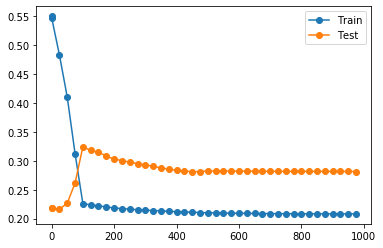

In [ ]:
net, opt = get_model('fcNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,x,y,(X_test[:,1:], X_test[:,:1]), opt,
                                                  loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

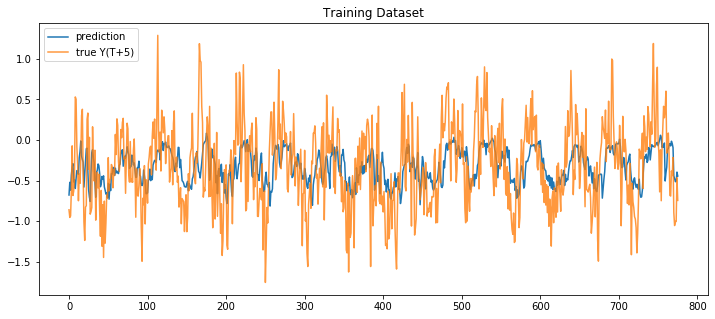

In [ ]:
net.eval()
plt.figure(figsize=[12,5])
plt.plot(net(x).detach().numpy(),label='prediction')
plt.plot(y.numpy(),label='true Y(T+5)',alpha=.8)
plt.legend()
plt.title('Training Dataset');

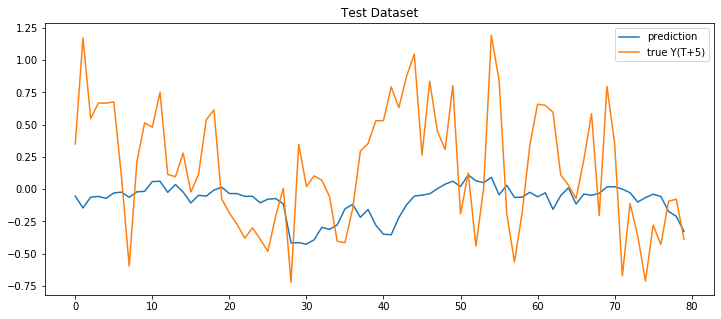

In [ ]:
net.eval()
plt.figure(figsize=[12,5])
plt.plot(net(X_test[:,1:]).detach().numpy(),label='prediction')
plt.plot(X_test[:,:1].numpy(),label='true Y(T+5)')
plt.legend()
plt.title('Test Dataset');

In [ ]:
# another way to calculate/re-calculate MSE loss for the model
from utils import mse
mse_loss_with_np = mse(net(X_test[:,1:]).detach().numpy(), X_test[:,:1].numpy()) # same as MSELoss()'s result
print('MSE loss:',mse_loss_with_np)

#### Lagged (Cross-) Correlation

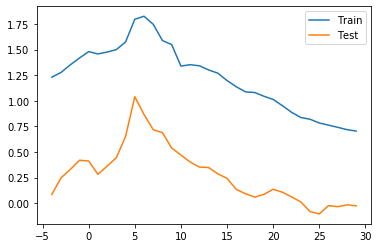

In [ ]:
from utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(X_test[:,1:]).detach().numpy().ravel(),
                                      X_test[:,:1].numpy().ravel())
lag_min = -5
lag_max = 30
train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
plt.plot(train_lags[train_mask],train_xcorr[train_mask],label='Train')

test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
plt.plot(lags[test_mask],y_xcorr[test_mask],label='Test')

plt.legend();

### Difference Net

In [ ]:
# Training data
with open('train_preprocessed_diff5.npy', 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open('test_preprocessed_diff5.npy', 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

Shapes
train: torch.Size([776, 7]) torch.float32,
test: torch.Size([80, 7]) torch.float32


In [ ]:
Y0 = X_train[:,1].reshape(-1,1).to(device) # Y(T+0),..., Y(T-5)
x = X_train[:,2:].to(device)
y = X_train[:,:1].to(device) # Y(T+5)

X_test = X_test.to(device)

In [ ]:
# Network size:
input_dim = x.shape[1]
layer_dims = [16,10,6,4]
dropout_p = [] # []: no dropout, [.2] : all p=0.2, [0.1, 0, .2,...]: layerwise
output_dim = 1
# Training parameters
repeat = 1       # number of training runs per configuration

learning_rate = 0.001 # default for Adam
epochs = 1000    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

epoch 0> train_loss: 0.3705148696899414, test_loss: 0.37878841161727905
epoch 100> train_loss: 0.3046850264072418, test_loss: 0.2979726493358612
epoch 200> train_loss: 0.2703647315502167, test_loss: 0.25961118936538696
epoch 300> train_loss: 0.26516062021255493, test_loss: 0.2598443031311035
epoch 400> train_loss: 0.26276320219039917, test_loss: 0.2590186893939972
epoch 500> train_loss: 0.26114746928215027, test_loss: 0.257391095161438
epoch 600> train_loss: 0.2601951062679291, test_loss: 0.2568275034427643
epoch 700> train_loss: 0.25962960720062256, test_loss: 0.2566981911659241
epoch 800> train_loss: 0.2592850625514984, test_loss: 0.25663134455680847
epoch 900> train_loss: 0.25907212495803833, test_loss: 0.2564704418182373


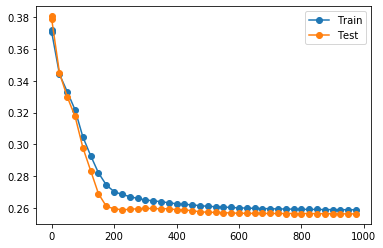

In [ ]:
net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate})

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((X_test[:,2:],X_test[:,1].reshape(-1,1)), X_test[:,:1]),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();

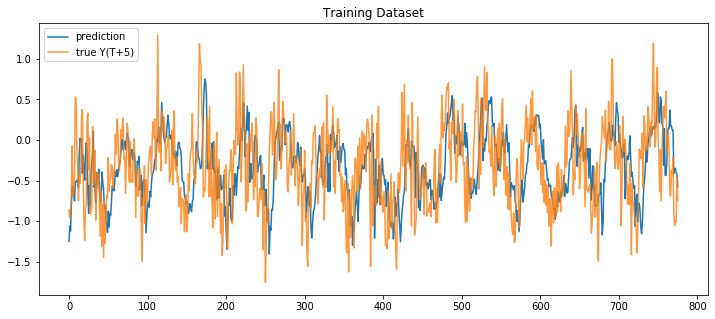

In [ ]:
net.eval()
plt.figure(figsize=[12,5])
plt.plot(net(x,Y0).detach().numpy(),label='prediction')
plt.plot(y.numpy(),label='true Y(T+5)',alpha=.8)
plt.legend()
plt.title('Training Dataset');

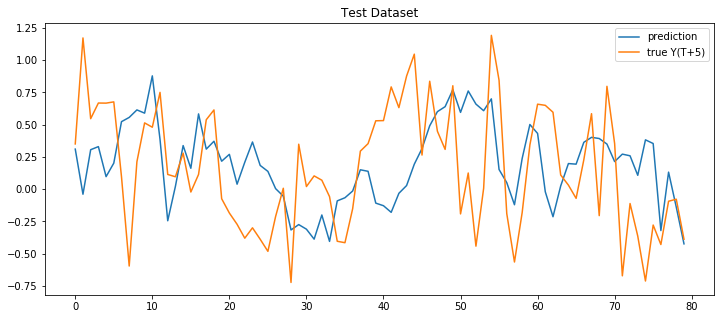

In [ ]:
net.eval()
plt.figure(figsize=[12,5])
plt.plot(net(X_test[:,2:],X_test[:,1].reshape(-1,1)).detach().numpy(),label='prediction')

plt.plot(X_test[:,:1].numpy(),label='true Y(T+5)')
plt.legend()
plt.title('Test Dataset');

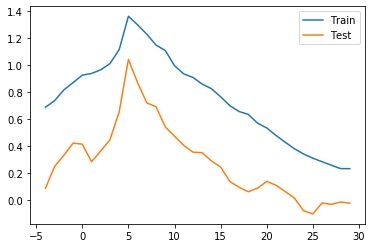

In [ ]:
from utils import lagged_xcorr

net.eval()
train_lags, train_xcorr = lagged_xcorr( net(x,Y0).detach().numpy().ravel(), 
                                        y.numpy().ravel())
test_lags, test_xcorr = lagged_xcorr( net(X_test[:,2:],X_test[:,1].reshape(-1,1)).detach().numpy().ravel(),
                                      X_test[:,:1].numpy().ravel())
lag_min = -5
lag_max = 30
train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
plt.plot(train_lags[train_mask],train_xcorr[train_mask],label='Train')

test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
plt.plot(lags[test_mask],y_xcorr[test_mask],label='Test')

plt.legend();